# Loan Approval Prediction
> Kaggle Playground Series - Season 4, Episode 10
> 
> https://www.kaggle.com/competitions/playground-series-s4e10/overview


## 1. Problem Defition
>  predict whether an applicant is approved for a loan.

## 2. Data
>The dataset for this competition (both train and test) was generated from a deep learning model trained on the Loan Approval Prediction dataset.
>
>https://www.kaggle.com/competitions/playground-series-s4e10/data

   ### Files
   * **train.csv** - the training dataset; loan_status is the binary target

   * **test.csv** - the test dataset; your objective is to predict probability of the target loan_status for each row

   * **sample_submission.csv** - a sample submission file in the correct format

## 3. Evaluation
> Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.


In [133]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay


In [91]:
# Loading our train data and take a look at it
df_train = pd.read_csv("../data/kaggle-loan-approval-playgroundS4E10-CatBoost/train.csv")
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [92]:
# Loading our test data and take a look at it
df_test = pd.read_csv("../data/kaggle-loan-approval-playgroundS4E10-CatBoost/test.csv")
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [93]:
# Creating a reusable Function to gives us a summary of our DataFrame
def summary(df):
    """
     This function will create a dataframe of usefull informations about a target dataFrame like:
         dtypes of each column
         missing value count of each column
         number of unique value in each column
         first and last value of a column as an example
    """
    print(f"Dataset Shape: {df.shape}")
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ = summ.reset_index()
    summ["Name"] = summ['index']
    summ.drop('index', axis=1, inplace=True)
    summ["Missing"] = df.isnull().sum().values
    summ["Missing %"] = df.isnull().sum().values * 100
    summ["Uniques"] = df.nunique().values
    summ["First Value"] = df.loc[0].values
    summ["Last Value"] = df.iloc[-1].values
    return summ

In [94]:
summary(df_train)

Dataset Shape: (58645, 13)


,dtypes,Name,Missing,Missing %,Uniques,First Value,Last Value
0,int64,id,0,0,58645,0,58644
1,int64,person_age,0,0,53,37,31
2,int64,person_income,0,0,2641,35000,75000
3,object,person_home_ownership,0,0,4,RENT,MORTGAGE
4,float64,person_emp_length,0,0,36,0.0,2.0
5,object,loan_intent,0,0,6,EDUCATION,VENTURE
6,object,loan_grade,0,0,7,B,B
7,int64,loan_amnt,0,0,545,6000,15000
8,float64,loan_int_rate,0,0,362,11.49,11.11
9,float64,loan_percent_income,0,0,61,0.17,0.2


In [95]:
# This will convert all non-numeric values to category values.
def non_numeric_to_category(df):
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()
    return df

In [110]:
# Calling our function to change all non-numeric values to category
df_train = non_numeric_to_category(df_train)

# Checking the summary again to make sure all columns are numeric or category
summary(df_train)

Dataset Shape: (58645, 13)


,dtypes,Name,Missing,Missing %,Uniques,First Value,Last Value
0,int64,id,0,0,58645,0,58644
1,int64,person_age,0,0,53,37,31
2,int64,person_income,0,0,2641,35000,75000
3,category,person_home_ownership,0,0,4,RENT,MORTGAGE
4,float64,person_emp_length,0,0,36,0.0,2.0
5,category,loan_intent,0,0,6,EDUCATION,VENTURE
6,category,loan_grade,0,0,7,B,B
7,int64,loan_amnt,0,0,545,6000,15000
8,float64,loan_int_rate,0,0,362,11.49,11.11
9,float64,loan_percent_income,0,0,61,0.17,0.2


### Doing some data engineering to build some more columns

In [141]:
def feature_eng(df_train):
    df_train["loantoincome"] = ((df_train["loan_amnt"] / df_train["person_income"])).astype(str).astype('category')
    df_train["loan_percent_incometoincome"] = ((df_train["loan_percent_income"] / df_train["person_income"])).astype(str).astype('category')
    df_train['person_age_to_person_income'] = (df_train['person_age'] / df_train['person_income']).astype(str).astype('category')
    df_train['person_emp_length_to_person_age'] = (df_train['person_emp_length'] / df_train['person_age']).astype(str).astype('category')
    df_train['loan_int_rate_to_loan_amnt'] = (df_train['loan_int_rate'] / df_train['loan_amnt']).astype(str).astype('category')

    return df_train

I will check this new features later to make sure they're useful or not

In [142]:
df_train = feature_eng(df_train)
summary(df_train)

Dataset Shape: (58645, 18)


,dtypes,Name,Missing,Missing %,Uniques,First Value,Last Value
0,int64,id,0,0,58645,0,58644
1,int64,person_age,0,0,53,37,31
2,int64,person_income,0,0,2641,35000,75000
3,category,person_home_ownership,0,0,4,RENT,MORTGAGE
4,float64,person_emp_length,0,0,36,0.0,2.0
5,category,loan_intent,0,0,6,EDUCATION,VENTURE
6,category,loan_grade,0,0,7,B,B
7,int64,loan_amnt,0,0,545,6000,15000
8,float64,loan_int_rate,0,0,362,11.49,11.11
9,float64,loan_percent_income,0,0,61,0.17,0.2


## Trying CatBoost :

In [135]:
X = df_train.drop("loan_status", axis=1)
y = df_train.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

model = CatBoostClassifier(
        cat_features=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loantoincome',
                      'loan_percent_incometoincome', 'person_age_to_person_income', 'person_emp_length_to_person_age', 'loan_int_rate_to_loan_amnt'],
        loss_function='Logloss',
        eval_metric='AUC')

model.fit(X_train, y_train)
model.score(X_test, y_test)

Learning rate set to 0.053283
0:	total: 53.3ms	remaining: 53.3s
1:	total: 106ms	remaining: 53s
2:	total: 150ms	remaining: 49.9s
3:	total: 202ms	remaining: 50.4s
4:	total: 255ms	remaining: 50.7s
5:	total: 296ms	remaining: 49.1s
6:	total: 331ms	remaining: 47s
7:	total: 366ms	remaining: 45.3s
8:	total: 421ms	remaining: 46.3s
9:	total: 469ms	remaining: 46.4s
10:	total: 526ms	remaining: 47.3s
11:	total: 576ms	remaining: 47.4s
12:	total: 620ms	remaining: 47.1s
13:	total: 673ms	remaining: 47.4s
14:	total: 727ms	remaining: 47.8s
15:	total: 780ms	remaining: 47.9s
16:	total: 827ms	remaining: 47.8s
17:	total: 877ms	remaining: 47.9s
18:	total: 933ms	remaining: 48.2s
19:	total: 988ms	remaining: 48.4s
20:	total: 1.04s	remaining: 48.5s
21:	total: 1.1s	remaining: 48.8s
22:	total: 1.16s	remaining: 49.3s
23:	total: 1.22s	remaining: 49.5s
24:	total: 1.27s	remaining: 49.6s
25:	total: 1.33s	remaining: 49.7s
26:	total: 1.37s	remaining: 49.5s
27:	total: 1.42s	remaining: 49.4s
28:	total: 1.47s	remaining: 49.2

0.9564327734674738

In [136]:
y_preds = model.predict(X_test)
roc_auc_score(y_test, y_preds)

0.8703100935432916

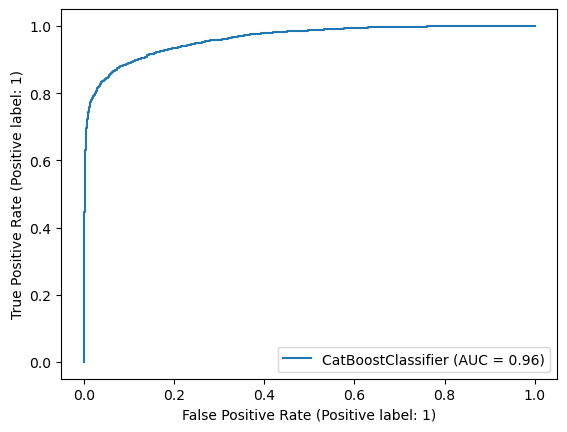

In [137]:
RocCurveDisplay.from_estimator(estimator=model, 
                               X=X_test, 
                               y=y_test); 

## Now lets train our model on all of our train dataset and test it on test.csv and submit an entry on kaggle to check our real score and ranking

In [138]:
X = df_train.drop("loan_status", axis=1)
y = df_train.loan_status

model = CatBoostClassifier(
        cat_features=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loantoincome',
                      'loan_percent_incometoincome', 'person_age_to_person_income', 'person_emp_length_to_person_age', 'loan_int_rate_to_loan_amnt'],
        loss_function='Logloss',
        eval_metric='AUC')

model.fit(X, y)

Learning rate set to 0.05861
0:	total: 66ms	remaining: 1m 5s
1:	total: 128ms	remaining: 1m 3s
2:	total: 185ms	remaining: 1m 1s
3:	total: 245ms	remaining: 1m 1s
4:	total: 306ms	remaining: 1m
5:	total: 365ms	remaining: 1m
6:	total: 425ms	remaining: 1m
7:	total: 484ms	remaining: 1m
8:	total: 537ms	remaining: 59.1s
9:	total: 598ms	remaining: 59.2s
10:	total: 661ms	remaining: 59.4s
11:	total: 729ms	remaining: 1m
12:	total: 789ms	remaining: 59.9s
13:	total: 848ms	remaining: 59.7s
14:	total: 910ms	remaining: 59.7s
15:	total: 969ms	remaining: 59.6s
16:	total: 1.03s	remaining: 59.7s
17:	total: 1.09s	remaining: 59.6s
18:	total: 1.16s	remaining: 59.9s
19:	total: 1.22s	remaining: 59.9s
20:	total: 1.28s	remaining: 59.9s
21:	total: 1.34s	remaining: 59.8s
22:	total: 1.43s	remaining: 1m
23:	total: 1.49s	remaining: 1m
24:	total: 1.55s	remaining: 1m
25:	total: 1.61s	remaining: 1m
26:	total: 1.68s	remaining: 1m
27:	total: 1.72s	remaining: 59.8s
28:	total: 1.77s	remaining: 59.4s
29:	total: 1.84s	remaining

In [139]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [143]:
df_test = non_numeric_to_category(df_test)
df_test = feature_eng(df_test)
summary(df_test)

Dataset Shape: (39098, 17)


,dtypes,Name,Missing,Missing %,Uniques,First Value,Last Value
0,int64,id,0,0,39098,58645,97742
1,int64,person_age,0,0,52,23,31
2,int64,person_income,0,0,2196,69000,45000
3,category,person_home_ownership,0,0,4,RENT,RENT
4,float64,person_emp_length,0,0,31,3.0,6.0
5,category,loan_intent,0,0,6,HOMEIMPROVEMENT,DEBTCONSOLIDATION
6,category,loan_grade,0,0,7,F,B
7,int64,loan_amnt,0,0,482,25000,19450
8,float64,loan_int_rate,0,0,336,15.76,9.91
9,float64,loan_percent_income,0,0,63,0.36,0.44


In [147]:
df_sample = pd.read_csv("../data/kaggle-loan-approval-playgroundS4E10-CatBoost/sample_submission.csv")
df_sample.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


In [150]:
y_preds = model.predict(df_test)
y_preds[:10]

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [151]:
final_df = pd.DataFrame()
final_df["id"] = df_test["id"]
final_df["loan_status"] = y_preds
final_df.head()

,id,loan_status
0,58645,1
1,58646,0
2,58647,0
3,58648,0
4,58649,0


In [152]:
final_df.to_csv("../data/kaggle-loan-approval-playgroundS4E10-CatBoost/loan_approval_preds_1.csv", index=False)

### got score of 0.87793 in kaggle and ranked 1313/1991 on first try